In [3]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import time

D:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
D:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
D:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [4]:
# 定义函数来提取SURF特征并绘制关键点
def extract_surf_features(image_path):
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    surf = cv2.xfeatures2d.SURF_create()
    keypoints, des = surf.detectAndCompute(gray_image, None)
    
    image_with_keypoints = cv2.drawKeypoints(gray_image, keypoints, image)
    # plt.imshow(image_with_keypoints)
    # plt.show()

    return des

# 定义函数来计算特征匹配
def compute_matches(des1, des2):
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    
    # 使用Lowe's ratio测试
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append([m])
            
    return len(good_matches)

In [5]:
# 定义函数进行图像检索
def image_retrieval(input_image_path, image_db_path):
    input_des = extract_surf_features(input_image_path)

    # 遍历数据库中的每张图像，计算特征匹配
    match_results = []
    for image_name in os.listdir(image_db_path):
        image_path = os.path.join(image_db_path, image_name)
        
        print("正在匹配图片：", image_path)
        
        db_des = extract_surf_features(image_path)
        
        num_matches = compute_matches(input_des, db_des)
        match_results.append((image_path, num_matches))

    # 按照相似度（匹配特征的数量）降序排序
    match_results.sort(key=lambda x: x[1], reverse=True)

    # 返回数据库中的图片路径，按相似度降序
    return match_results

def image_retrieval_hist(input_image_path, image_paths):
    input_des = extract_surf_features(input_image_path)
    
    match_results = []
    for image_path in image_paths:
        db_des = extract_surf_features(image_path)
        num_matches = compute_matches(input_des, db_des)
        match_results.append((image_path, num_matches))
    match_results.sort(key=lambda x: x[1], reverse=True)
    
    return match_results

In [6]:
# 颜色直方图预筛选函数
def calc_hist(image_path):
    image = cv2.imread(image_path)
    hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

def compare_hist(hist1, hist2):
    return cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)

def preselect_by_color(input_image_path, image_db_path, topN=10):
    input_hist = calc_hist(input_image_path)
    
    hist_db = []
    for image_name in os.listdir(image_db_path):
        image_path = os.path.join(image_db_path, image_name)
        db_hist = calc_hist(image_path)
        similarity = compare_hist(input_hist, db_hist)
        hist_db.append((image_path, similarity))
    
    hist_db.sort(key=lambda x: x[1], reverse=True)
    return hist_db[:topN]

Elapsed time: 10.815075874328613 seconds
Image path: ./data/1 (1).jpg, Number of matches: 1975
Image path: ./data/1 (14).jpg, Number of matches: 19
Image path: ./data/1 (16).jpg, Number of matches: 16
Image path: ./data/1 (3).jpg, Number of matches: 14
Image path: ./data/1 (24).jpg, Number of matches: 13
Image path: ./data/1 (10).jpg, Number of matches: 10
Image path: ./data/1 (12).jpg, Number of matches: 8
Image path: ./data/1 (5).jpg, Number of matches: 7
Image path: ./data/1 (20).jpg, Number of matches: 7
Image path: ./data/1 (15).jpg, Number of matches: 1


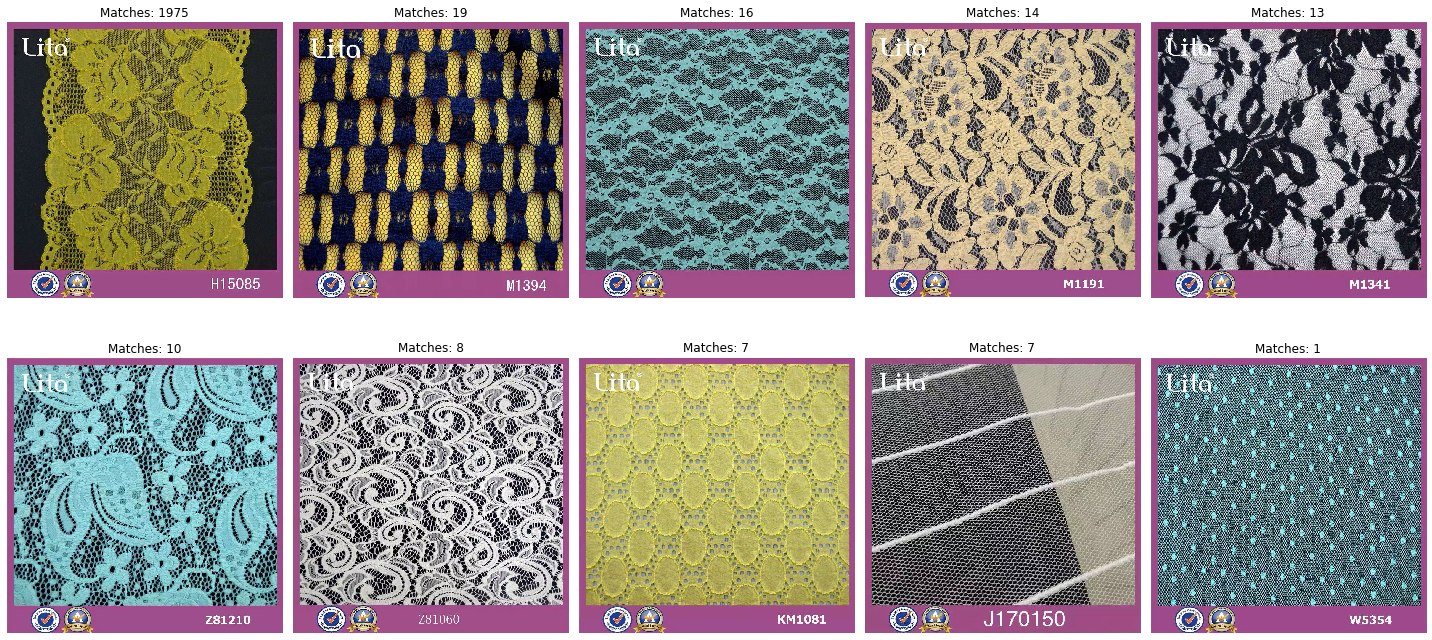

In [12]:
# 使用函数
input_image_path = "test1-1.jpg"
image_db_path = "./data/"

# 首先进行颜色直方图预筛选
preselected_images = preselect_by_color(input_image_path, image_db_path)

# 提取预筛选图片的路径
preselected_image_paths = [image_path for image_path, _ in preselected_images]

# print(preselected_image_paths)

start_time = time.time()

# 对预筛选出的图像进行SURF方法
match_results = image_retrieval_hist(input_image_path, preselected_image_paths)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

# 打印结果并显示最相似的前10张图像
fig = plt.figure(figsize=(20, 10))
for i, (image_path, num_matches) in enumerate(match_results[:10]):
    print(f"Image path: {image_path}, Number of matches: {num_matches}")
    
    # 读取图像并显示
    img = mpimg.imread(image_path)
    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(img)
    ax.set_title(f"Matches: {num_matches}")
    ax.axis('off')

plt.tight_layout()
plt.show()